## average/conflict speed v.s. minTTC relationship

In [1]:
import pickle
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# import scienceplots
from tqdm import tqdm
from shapely import LineString, Point
from seaborn import displot, histplot, relplot
plt.style.use(['seaborn-v0_8-paper'])
# plt.style.use(['ieee', 'notebook'])
from scipy import stats
from waymo_devkit.conflict import Conflict

In [2]:
with open('./pkl/conflict_pet15s.pkl', 'rb') as file:
    conflict_list_from_pickle = pickle.load(file)
print(f"#Conflicts: {len(conflict_list_from_pickle)}")

conflict_list = list()
for c in conflict_list_from_pickle:
    conflict_list.append(
        Conflict(
            leader_id=c['leader_id'],
            leader_index=c['leader_index'],
            leader_states=c['leader_states'],
            leader_time_at_conflict=c['leader_time_at_conflict'],
            follower_id=c['follower_id'],
            follower_index=c['follower_index'],
            follower_states=c['follower_states'],
            follower_time_at_conflict=c['follower_time_at_conflict'],
            PET=c['PET'],
            conflict_type=c['conflict_type'],
            leader_is_av=c['leader_is_av'],
            follower_is_av=c['follower_is_av'],
            center=c['center'],
            radius=c['radius'],
    ))

#Conflicts: 889


In [3]:
"""
Construct a dataframe with the following columns:
- Conflict type
- Vehicle order
- PET
- minTTC
- leader_avg_v
- follower_avg_v
- leader_conflict_v
- follower_conflict_v
"""
conflict_cols_in_df = [
    "Conflict type",
    "Vehicle order",
    "PET",
    # "minTTC",
    "leader_avg_v",
    "follower_avg_v",
    "leader_conflict_v",
    "follower_conflict_v",
]

# generate each rows in the dataframe
conflict_rows_in_df = list()
for index, conflict in tqdm(enumerate(conflict_list)):

    leader_type = "AV" if conflict.leader_is_av else "HV"
    follower_type = "AV" if conflict.follower_is_av else "HV" 
    conflict_type = "Cross" if conflict.conflict_type == "CROSS" else "Merge"
    conflict_rows_in_df.append([
        conflict_type,
        leader_type+"-"+follower_type,
        conflict.PET,
        # conflict.minimum_TTC,
        conflict.leader_average_speed,
        conflict.follower_average_speed,
        conflict.leader_conflict_speed,
        conflict.follower_conflict_speed,
    ])
conflict_df = pd.DataFrame(conflict_rows_in_df, columns=conflict_cols_in_df)

# Post-process
PET_THRESHOLD = 10
conflict_df = conflict_df[conflict_df["PET"] <= PET_THRESHOLD]

# display info
conflict_df.info()
conflict_df.to_csv("./outputs/waymo_follower_speed.csv")

889it [00:00, 121224.24it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 864 entries, 0 to 888
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Conflict type        864 non-null    object 
 1   Vehicle order        864 non-null    object 
 2   PET                  864 non-null    float64
 3   leader_avg_v         864 non-null    float64
 4   follower_avg_v       864 non-null    float64
 5   leader_conflict_v    864 non-null    float64
 6   follower_conflict_v  864 non-null    float64
dtypes: float64(5), object(2)
memory usage: 54.0+ KB


In [4]:
# # Post-process: remove minTTC greater than 10s
# minTTC_THRESHOLD = 10
# conflict_df = conflict_df[conflict_df["minTTC"] <= minTTC_THRESHOLD]

# # display info
# conflict_df.info()

In [5]:
conflict_df[["Conflict type", "Vehicle order"]].value_counts()

Conflict type  Vehicle order
Cross          HV-HV            283
               AV-HV            149
               HV-AV            142
Merge          AV-HV            135
               HV-HV            107
               HV-AV             48
dtype: int64

In [6]:
conflict_df.groupby(["Conflict type", "Vehicle order"])['follower_conflict_v'].mean()

Conflict type  Vehicle order
Cross          AV-HV            5.980187
               HV-AV            6.276487
               HV-HV            6.532744
Merge          AV-HV            6.062903
               HV-AV            6.335611
               HV-HV            7.084569
Name: follower_conflict_v, dtype: float64

In [7]:
conflict_df.groupby(["Conflict type", "Vehicle order"])['follower_conflict_v'].std()

Conflict type  Vehicle order
Cross          AV-HV            1.263567
               HV-AV            1.370453
               HV-HV            1.358506
Merge          AV-HV            1.820519
               HV-AV            2.226063
               HV-HV            2.162147
Name: follower_conflict_v, dtype: float64

In [8]:
HVHV = conflict_df[conflict_df["Vehicle order"] == "HV-HV"]
AVHV = conflict_df[conflict_df["Vehicle order"] == "AV-HV"]
HVAV = conflict_df[conflict_df["Vehicle order"] == "HV-AV"]

cross_df = conflict_df[conflict_df["Conflict type"] == "Cross"]
merge_df = conflict_df[conflict_df["Conflict type"] == "Merge"]

HVHV_cross = cross_df[cross_df["Vehicle order"] == "HV-HV"]
AVHV_cross = cross_df[cross_df["Vehicle order"] == "AV-HV"]
HVAV_cross = cross_df[cross_df["Vehicle order"] == "HV-AV"]

HVHV_merge = merge_df[merge_df["Vehicle order"] == "HV-HV"]
AVHV_merge = merge_df[merge_df["Vehicle order"] == "AV-HV"]
HVAV_merge = merge_df[merge_df["Vehicle order"] == "HV-AV"]

## ANOVA

In [11]:
stats.f_oneway(HVHV_merge.follower_conflict_v, HVAV_merge.follower_conflict_v, AVHV_merge.follower_conflict_v)

F_onewayResult(statistic=7.782095002080246, pvalue=0.0005113723366000246)

In [12]:
stats.f_oneway(HVHV_cross.follower_conflict_v, HVAV_cross.follower_conflict_v, AVHV_cross.follower_conflict_v)

F_onewayResult(statistic=8.457694153426152, pvalue=0.00024000792993361455)

## T-test

cross

In [18]:
stats.ttest_ind(HVHV_cross['follower_conflict_v'], HVAV_cross['follower_conflict_v'])

Ttest_indResult(statistic=1.8288665460944462, pvalue=0.06812351866884583)

In [19]:
stats.ttest_ind(HVHV_cross['follower_conflict_v'], AVHV_cross['follower_conflict_v'])

Ttest_indResult(statistic=4.115118115502873, pvalue=4.6394730469923634e-05)

In [20]:
stats.ttest_ind(HVAV_cross['follower_conflict_v'], AVHV_cross['follower_conflict_v'])

Ttest_indResult(statistic=1.9186772877245888, pvalue=0.05601011313865202)

In [21]:
stats.ttest_ind(HVHV_merge['follower_conflict_v'], HVAV_merge['follower_conflict_v'])

Ttest_indResult(statistic=1.9758480330848114, pvalue=0.049970494017929815)

In [22]:
stats.ttest_ind(HVHV_merge['follower_conflict_v'], AVHV_merge['follower_conflict_v'])

Ttest_indResult(statistic=3.989166918048768, pvalue=8.809096296219358e-05)

In [23]:
stats.ttest_ind(HVAV_merge['follower_conflict_v'], AVHV_merge['follower_conflict_v'])

Ttest_indResult(statistic=0.8390715364308224, pvalue=0.4025359799159466)

## Mann-Whitney U Test

cross

In [24]:
stats.mannwhitneyu(
    x=HVHV_cross['follower_conflict_v'],
    y=HVAV_cross['follower_conflict_v'],
    alternative='two-sided',
) # pvalue=0.05557640845035958

MannwhitneyuResult(statistic=22380.0, pvalue=0.05557640845035958)

In [25]:
stats.mannwhitneyu(
    x=HVHV_cross['follower_conflict_v'],
    y=AVHV_cross['follower_conflict_v'],
    alternative='two-sided',
) # pvalue=0.0001566423951354355

MannwhitneyuResult(statistic=25747.0, pvalue=0.0001566423951354355)

In [27]:
stats.mannwhitneyu(
    x=HVAV_cross['follower_conflict_v'],
    y=AVHV_cross['follower_conflict_v'],
    alternative='two-sided',
)

MannwhitneyuResult(statistic=11635.0, pvalue=0.14128428739791513)

merge

In [28]:
stats.mannwhitneyu(
    x=HVHV_merge['follower_conflict_v'],
    y=HVAV_merge['follower_conflict_v'],
    alternative='two-sided',
) # pvalue=0.08468902336556436

MannwhitneyuResult(statistic=3014.0, pvalue=0.08468902336556436)

In [29]:
stats.mannwhitneyu(
    x=HVHV_merge['follower_conflict_v'],
    y=AVHV_merge['follower_conflict_v'],
    alternative='two-sided',
) # pvalue=pvalue=4.939350347792966e-05

MannwhitneyuResult(statistic=9418.0, pvalue=4.939350347792966e-05)

In [31]:
stats.mannwhitneyu(
    x=HVAV_merge['follower_conflict_v'],
    y=AVHV_merge['follower_conflict_v'],
    alternative='two-sided',
)  # pvalue=0.3838435052061602

MannwhitneyuResult(statistic=3515.0, pvalue=0.3838435052061602)

<Figure size 900x300 with 0 Axes>

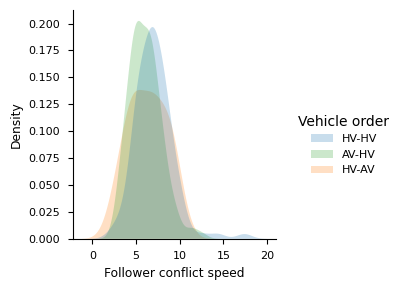

In [6]:
palette = {
    "HV-HV" : '#257ab6', 
    "AV-HV" : '#31a231',
    "HV-AV" : '#ff8214',
}

FIGURE_WIDTH, FIGURE_HEIGHT = 3, 3
plt.figure(figsize=(FIGURE_WIDTH*3, FIGURE_HEIGHT))
g = displot(
    data=conflict_df[conflict_df["Conflict type"] == "Merge"],
    x="follower_conflict_v",
    kind="kde",
    hue="Vehicle order",
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    fill=True,
    palette=palette,
    common_norm=False,
    ec=None,
    height=3,
    aspect=1,
)
g.axes[0,0].set_xlabel("Follower conflict speed")
plt.savefig(f"./outputs/plots/waymo_distplot_follower_conflict_speed_Merge.png", dpi=300, bbox_inches="tight")
conflict_df[conflict_df["Conflict type"] == "Merge"].to_csv("./waymo_f_conflict_speed_merge.csv")

<Figure size 900x300 with 0 Axes>

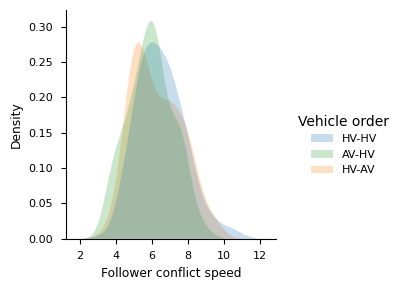

In [75]:
FIGURE_WIDTH, FIGURE_HEIGHT = 3, 3
plt.figure(figsize=(FIGURE_WIDTH*3, FIGURE_HEIGHT))
g = displot(
    data=conflict_df[conflict_df["Conflict type"] == "Cross"],
    x="follower_conflict_v",
    kind="kde",
    hue="Vehicle order",
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    fill=True,
    palette=palette,
    common_norm=False,
    ec=None,
    height=3,
    aspect=1,
)
g.axes[0,0].set_xlabel("Follower conflict speed")
plt.savefig(f"./outputs/plots/waymo_distplot_follower_conflict_speed_Cross.png", dpi=300, bbox_inches="tight")
conflict_df[conflict_df["Conflict type"] == "Cross"].to_csv("./waymo_f_conflict_speed_cross.csv")

<Figure size 900x300 with 0 Axes>

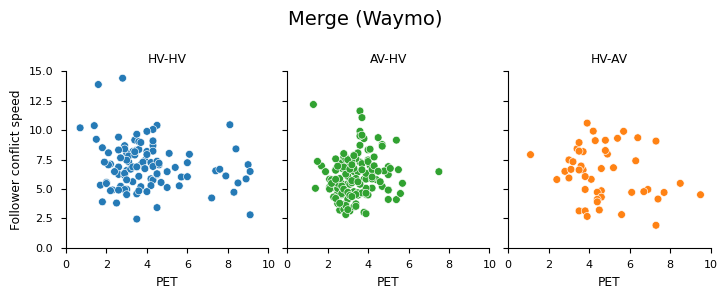

In [20]:
palette = {
    "HV-HV" : '#257ab6', 
    "AV-HV" : '#31a231',
    "HV-AV" : '#ff8214',
}
FIGURE_WIDTH, FIGURE_HEIGHT = 3, 3
plt.figure(figsize=(FIGURE_WIDTH*3, FIGURE_HEIGHT))
conflictType = "Merge"

g = relplot(
    data=conflict_df[conflict_df["Conflict type"] == conflictType], 
    x="PET",
    y="follower_conflict_v",
    hue="Vehicle order",
    col="Vehicle order",
    col_order=["HV-HV", "AV-HV", "HV-AV"],
    palette=palette,
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    height=FIGURE_HEIGHT,
    aspect=0.8,
    legend=False,
)
g.fig.suptitle(f"{conflictType} (Waymo)", size=14)
# g.fig.subplots_adjust(top=.9)
g.set_titles("{col_name}").tight_layout(w_pad=1)
g.axes[0,0].set_ylabel("Follower conflict speed")
g.axes[0,0].set_xlim([0, PET_THRESHOLD])
g.axes[0,0].set_ylim([0, 15])
plt.savefig(f"./outputs/plots/waymo_scatterplot_follower_conflict_speed_PET_{conflictType}.png", dpi=300, bbox_inches="tight")


<Figure size 900x300 with 0 Axes>

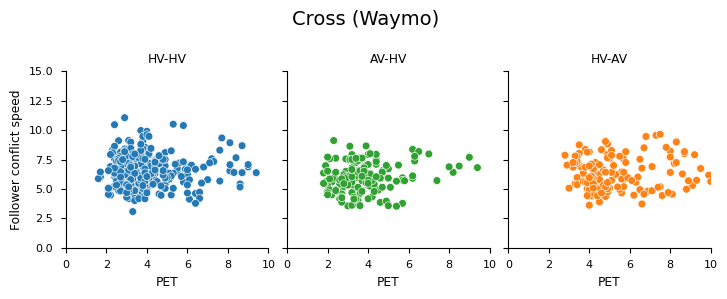

In [14]:
palette = {
    "HV-HV" : '#257ab6', 
    "AV-HV" : '#31a231',
    "HV-AV" : '#ff8214',
}
FIGURE_WIDTH, FIGURE_HEIGHT = 3, 3
plt.figure(figsize=(FIGURE_WIDTH*3, FIGURE_HEIGHT))
conflictType = "Cross"

g = relplot(
    data=conflict_df[conflict_df["Conflict type"] == conflictType], 
    x="PET",
    y="follower_conflict_v",
    hue="Vehicle order",
    col="Vehicle order",
    col_order=["HV-HV", "AV-HV", "HV-AV"],
    palette=palette,
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    height=FIGURE_HEIGHT,
    aspect=0.8,
    legend=False,
)
g.fig.suptitle(f"{conflictType} (Waymo)", size=14)
# g.fig.subplots_adjust(top=.9)
g.set_titles("{col_name}").tight_layout(w_pad=1)
g.axes[0,0].set_ylabel("Follower conflict speed")
g.axes[0,0].set_xlim([0, PET_THRESHOLD])
g.axes[0,0].set_ylim([0, 15])
plt.savefig(f"./outputs/plots/waymo_scatterplot_follower_conflict_speed_PET_{conflictType}.png", dpi=300, bbox_inches="tight")

## Conflict speed VS minTTC

### Follower

<Figure size 900x300 with 0 Axes>

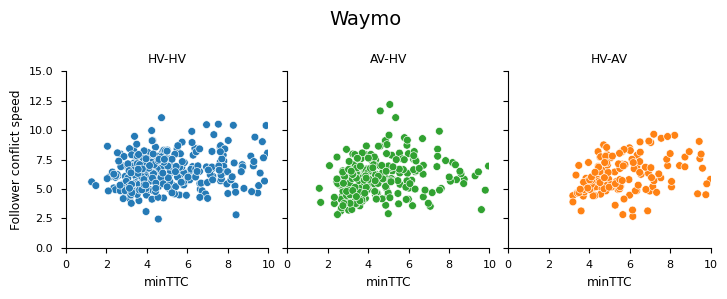

In [13]:
palette = {
    "HV-HV" : '#257ab6', 
    "AV-HV" : '#31a231',
    "HV-AV" : '#ff8214',
}
FIGURE_WIDTH, FIGURE_HEIGHT = 3, 3
plt.figure(figsize=(FIGURE_WIDTH*3, FIGURE_HEIGHT))

g = relplot(
    data=conflict_df, 
    x="minTTC",
    y="follower_conflict_v",
    hue="Vehicle order",
    col="Vehicle order",
    col_order=["HV-HV", "AV-HV", "HV-AV"],
    palette=palette,
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    height=FIGURE_HEIGHT,
    aspect=0.8,
    legend=False,
)
g.fig.suptitle("Waymo", size=14)
# g.fig.subplots_adjust(top=.9)
g.set_titles("{col_name}").tight_layout(w_pad=1)
g.axes[0,0].set_ylabel("Follower conflict speed")
g.axes[0,0].set_xlim([0, minTTC_THRESHOLD])
g.axes[0,0].set_ylim([0, 15])
plt.savefig("./outputs/plots/waymo_scatterplot_follower_conflictspeed_minTTC_Total.png", dpi=300, bbox_inches="tight")

### Leader

<Figure size 900x300 with 0 Axes>

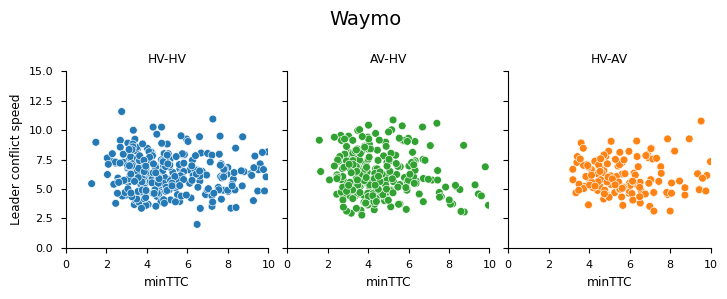

In [14]:
palette = {
    "HV-HV" : '#257ab6', 
    "AV-HV" : '#31a231',
    "HV-AV" : '#ff8214',
}
FIGURE_WIDTH, FIGURE_HEIGHT = 3, 3
plt.figure(figsize=(FIGURE_WIDTH*3, FIGURE_HEIGHT))

g = relplot(
    data=conflict_df, 
    x="minTTC",
    y="leader_conflict_v",
    hue="Vehicle order",
    col="Vehicle order",
    col_order=["HV-HV", "AV-HV", "HV-AV"],
    palette=palette,
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    height=FIGURE_HEIGHT,
    aspect=0.8,
    legend=False,
)
g.fig.suptitle("Waymo", size=14)
# g.fig.subplots_adjust(top=.9)
g.set_titles("{col_name}").tight_layout(w_pad=1)
g.axes[0,0].set_ylabel("Leader conflict speed")
g.axes[0,0].set_xlim([0, minTTC_THRESHOLD])
g.axes[0,0].set_ylim([0, 15])
plt.savefig("./outputs/plots/waymo_scatterplot_leader_conflictspeed_minTTC_Total.png", dpi=300, bbox_inches="tight")

## Average speed VS minTTC

### Follower

<Figure size 900x300 with 0 Axes>

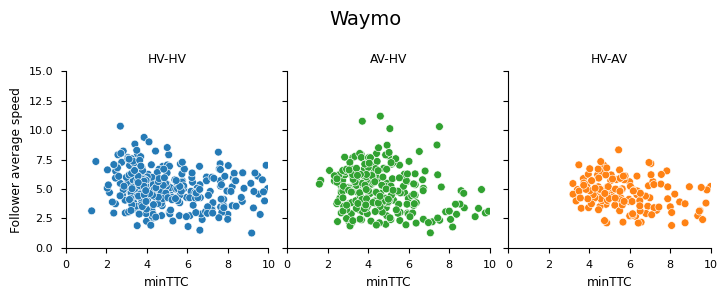

In [10]:
palette = {
    "HV-HV" : '#257ab6', 
    "AV-HV" : '#31a231',
    "HV-AV" : '#ff8214',
}
FIGURE_WIDTH, FIGURE_HEIGHT = 3, 3
plt.figure(figsize=(FIGURE_WIDTH*3, FIGURE_HEIGHT))

g = relplot(
    data=conflict_df, 
    x="minTTC",
    y="follower_avg_v",
    hue="Vehicle order",
    col="Vehicle order",
    col_order=["HV-HV", "AV-HV", "HV-AV"],
    palette=palette,
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    height=FIGURE_HEIGHT,
    aspect=0.8,
    legend=False,
)
g.fig.suptitle("Waymo", size=14)
# g.fig.subplots_adjust(top=.9)
g.set_titles("{col_name}").tight_layout(w_pad=1)
g.axes[0,0].set_ylabel("Follower average speed")
g.axes[0,0].set_xlim([0, minTTC_THRESHOLD])
g.axes[0,0].set_ylim([0, 15])

plt.savefig("./outputs/plots/waymo_scatterplot_follower_avgspeed_minTTC_Total.png", dpi=300, bbox_inches="tight")

### Leader

<Figure size 900x300 with 0 Axes>

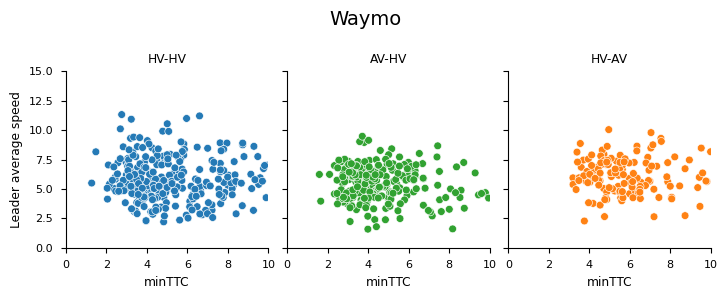

In [15]:
palette = {
    "HV-HV" : '#257ab6', 
    "AV-HV" : '#31a231',
    "HV-AV" : '#ff8214',
}
FIGURE_WIDTH, FIGURE_HEIGHT = 3, 3
plt.figure(figsize=(FIGURE_WIDTH*3, FIGURE_HEIGHT))

g = relplot(
    data=conflict_df, 
    x="minTTC",
    y="leader_avg_v",
    hue="Vehicle order",
    col="Vehicle order",
    col_order=["HV-HV", "AV-HV", "HV-AV"],
    palette=palette,
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    height=FIGURE_HEIGHT,
    aspect=0.8,
    legend=False,
)
g.fig.suptitle("Waymo", size=14)
# g.fig.subplots_adjust(top=.9)
g.set_titles("{col_name}").tight_layout(w_pad=1)
g.axes[0,0].set_ylabel("Leader average speed")
g.axes[0,0].set_xlim([0, minTTC_THRESHOLD])
g.axes[0,0].set_ylim([0, 15])
plt.savefig("./outputs/plots/waymo_scatterplot_leader_avgspeed_minTTC_Total.png", dpi=300, bbox_inches="tight")

## Scatter xy: speed, z: PET/minTTC

<Figure size 900x300 with 0 Axes>

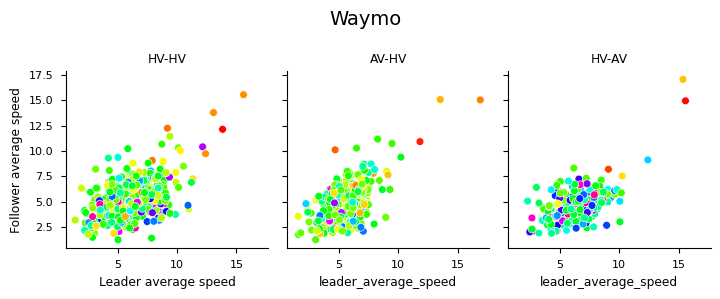

In [31]:
plt.figure(figsize=(FIGURE_WIDTH*3, FIGURE_HEIGHT))

g = relplot(
    data=conflict_df, 
    x="leader_average_speed",
    y="follower_average_speed",
    # size=0.1,
    hue="PET",
    col="Vehicle order",
    col_order=["HV-HV", "AV-HV", "HV-AV"],
    palette="hsv",
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    height=FIGURE_HEIGHT,
    aspect=0.8,
    legend=False,
)
g.fig.suptitle("Waymo", size=14)
# g.fig.subplots_adjust(top=.9)
g.set_titles("{col_name}").tight_layout(w_pad=1)
g.axes[0,0].set_xlabel("Leader average speed")
g.axes[0,0].set_ylabel("Follower average speed")
# g.axes[0,0].set_ylim([0,18])
# g.axes[0,0].set_xlim([0,10])
plt.savefig("./outputs/plots/avespeed_xy_PET_z.png", dpi=300, bbox_inches="tight")